In [1]:
import os
import pandas as pd
import janitor
import numpy as np


dfs = {}

ruta = os.path.join('..', 'data')

years = range(2019, 2024)

for year in years:
    file_path = os.path.join(ruta, f'{year}clean.csv')  # crea la ruta al archivo
    dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario

df2019 = dfs['df2019']
df2020 = dfs['df2020']
df2021 = dfs['df2021']
df2022 = dfs['df2022']
df2023 = dfs['df2023']

df2019['ano']=2019
df2020['ano']=2020
df2021['ano']=2021
df2022['ano']=2022
df2023['ano']=2023


for name, df in dfs.items():
    dfs[name] = df.clean_names()

/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_29998/3664601328.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_29998/3664601328.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_29998/3664601328.py:15: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_29998/3664601328.py:15: DtypeWarning: Columns (6,20,42,43) have m

In [2]:
# Crear una lista de dataframes
dfs_list = [dfs[name] for name in dfs.keys()]

# Concatenar todos los dataframes
contratos_df = pd.concat(dfs_list, ignore_index=True)


In [3]:
from currency_converter import CurrencyConverter


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'object':
        contratos_df[column] = contratos_df[column].str.upper()


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'string':
        contratos_df[column] = contratos_df[column].str.upper()

c = CurrencyConverter()
currencies=['USD', 'CAD', 'EUR', 'GBP', 'JPY']

# Create a dictionary to store conversion rates
conversion_rates = {}

for m in currencies:
    conversion_rate = c.convert(1, m, 'MXN')
    print(1, m, "=", conversion_rate, 'MXN')
    conversion_rates[m] = conversion_rate

# Apply conversion rates
contratos_df["importe"] = contratos_df["importe_del_contrato"]

for currency, conversion_rate in conversion_rates.items():
    contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , 'importe'] = contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , "importe_del_contrato"] * conversion_rate

print('Done')


1 USD = 17.115130976369297 MXN
1 CAD = 13.018183084854396 MXN
1 EUR = 18.6863 MXN
1 GBP = 21.75912340762477 MXN
1 JPY = 0.11946998273767662 MXN
Done


In [48]:

def correct_swap(df):
    # Define un patrón de RFC válido
    rfc_pattern = r"^[A-ZÑ&]{3,4}[0-9]{2}(0[1-9]|1[0-2])(0[1-9]|1[0-9]|2[0-9]|3[0-1])[A-Z0-9]?[A-Z0-9]?[0-9A]$"

    # Rellena los NaN con una cadena vacía para poder aplicar str.match
    df.fillna("", inplace=True)

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es un RFC válido
    mask_invalid = ~df['rfc'].str.match(rfc_pattern) & df['proveedor_o_contratista'].str.match(rfc_pattern)

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas
    df.loc[mask_invalid, 'rfc'], df.loc[mask_invalid, 'proveedor_o_contratista'] = df.loc[mask_invalid, 'proveedor_o_contratista'], df.loc[mask_invalid, 'rfc']

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es una cadena vacía
    mask_invalid_empty = ~df['rfc'].str.match(rfc_pattern) & (df['proveedor_o_contratista'] == "")

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas y asigna un valor artificial a 'rfc'
    df.loc[mask_invalid_empty, 'rfc'], df.loc[mask_invalid_empty, 'proveedor_o_contratista'] = 'XAXX010101000', df.loc[mask_invalid_empty, 'rfc']

    # Reemplaza las cadenas vacías con NaN de nuevo
    df.replace("", np.nan, inplace=True)

    return df

# Supón que contratos_df es tu DataFrame original
contratos_df = correct_swap(contratos_df)


In [49]:
def verify_correction(df):
    # Identificar filas donde rfc tiene una longitud distinta a 13
    mask = df['rfc'].str.len() != 12
    # Retornar filas donde rfc tiene una longitud distinta a 13
    return df.loc[mask]

verify_correction(contratos_df[['rfc', 'proveedor_o_contratista']])

,rfc,proveedor_o_contratista
14895,XAXX010101000,ARBAVEL A.C.
16833,XAXX010101000,JESUS GARCIA
16973,XAXX010101000,DAVID ROMERO
21692,XAXX010101000,CRUZ ROBLEDO
23257,XAXX010101000,PAVLO GETMAN
...,...,...
471121,XAXX010101000,FRANCISCO JAVIER MONROY SANCHEZ
471122,XAXX010101000,ALEXIA ANAEL AVILA SOLIS
471137,XAXX010101000,JOSE DE JESUS DIAZ CORONA
471138,XAXX010101000,TOMAS ESPINOZA BENAVIDES


### Función de búsqueda

In [53]:
import re

# Función de filtrado
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution_input = input("Por favor, ingresa las siglas de las instituciones separadas por comas (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Solicita al usuario el año
    year = input("Por favor, ingresa el año (déjalo en blanco para mostrar todos): ")

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        search_terms = [term.strip() for term in search_term.split(',')]
        search_conditions = [filtered_df['proveedor_o_contratista'].str.contains(term, case=False) | filtered_df['rfc'].str.contains(term, case=False) for term in search_terms]
        combined_search_condition = pd.concat(search_conditions, axis=1).any(axis=1)
        filtered_df = filtered_df.loc[combined_search_condition]

    # Filtra por institución si se proporciona
    if institution_input != 'TODAS' and institution_input:
        institutions = institution_input.split(',')
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'].isin(institutions)]

    # Filtra por año si se proporciona
    if year:
        filtered_df = filtered_df.loc[filtered_df['ano'] == int(year)]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        keywords = '|'.join(re.escape(keyword.strip()) for keyword in keywords.split(','))
        filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keywords, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        exclude_words = '|'.join(re.escape(word.strip()) for word in exclude_words.split(','))
        filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(exclude_words, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df


# Búsqueda

In [54]:
# Usa la función:
buscar = filter_contratos(contratos_df)
buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'ano']]

,tipo_de_procedimiento,siglas_de_la_institucion,titulo_del_contrato,descripcion_del_contrato,rfc,proveedor_o_contratista,importe,direccion_del_anuncio,ano
460734,NaN,BIENESTAR,SERVICIO DE ARRENDAMIENTO DE TRANSPORTE VEHICU...,SERVICIO DE ARRENDAMIENTO DE TRANSPORTE VEHICU...,AAN910409I35,INTEGRA ARRENDA SA DE CV SOFOM ENR,"3,641,577,670.08",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2023
54434,OTRAS CONTRATACIONES,BIENESTAR,SERVICIO DE ARRENDAMIENTO DE TRANSPORTE VEHICU...,SERVICIO DE ARRENDAMIENTO DE TRANSPORTE VEHICU...,CVA910402GI5,CASANOVA VALLEJO SA DE CV,"630,942,103.8",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2019
124481,LICITACIÓN PÚBLICA,BIENESTAR,SERVICIO INTEGRAL DEL CENTRO DE CONTACTO,SERVICIO DE CENTRO DE INFORMACIÓN SOBRE EL PRO...,BEG141128JD5,BUFETE EMPRESARIAL GTI SA DE CV,"530,757,375.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
400477,LICITACIÓN PÚBLICA,BIENESTAR,SERVICIO DE IMPRESIÓN PARA LA PROMOCIÓN Y OPER...,SERVICIO DE IMPRESIÓN PARA LA PROMOCIÓN Y OPER...,IOS010313EG7,IMPRESORES EN OFFSET Y SERIGRAFIA SC DE RL DE CV,"413,686,137.5",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
162273,LICITACIÓN PÚBLICA,BIENESTAR,SERVICIO DE IMPRESIÓN PARA LA PROMOCIÓN Y OPER...,SERVICIO DE IMPRESIÓN PARA LA PROMOCIÓN Y OPER...,IOS010313EG7,IMPRESORES EN OFFSET Y SERIGRAFIA SC DE RL DE CV,"381,597,790.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
...,...,...,...,...,...,...,...,...,...
272321,ADJUDICACIÓN DIRECTA,BIENESTAR,SERVICIO DE IMPRESIÓN DE CARPETAS CON MATERIAL...,SERVICIO DE IMPRESIÓN DE CARPETAS CON MATERIAL...,DCP190816KE1,DISTRIBUIDORA Y COMERCIALIZADORA DE PRODUCTOS ...,0.0,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
125553,ADJUDICACIÓN DIRECTA,BIENESTAR,ADQUISICIÓN DE VALES DE GASOLINA CM,ADQUISICIÓN DE VALES DE GASOLINA DENTRO DEL CO...,EFE8908015L3,EFECTIVALE S DE RL DE CV,0.0,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
156046,ADJUDICACIÓN DIRECTA,BIENESTAR,ADQUISICION DE MATERIAL DE LIMPIEZA,ADQUISICION DE MATERIAL DE LIMPIEZA,PAP150915TN3,P & P IMAGENES DIAGNOSTICAS SA DE CV,0.0,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
283447,ADJUDICACIÓN DIRECTA,BIENESTAR,SERVICIO DE CONSERVACIÓN Y MANTENIMIENTO SECRE...,SERVICIO DE MANTENIMIENTO Y CONSERVACION DE IN...,CUM020403FC2,CUMICSA CONSTRUCCIONES SA DE CV,0.0,HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021



### Resultados de búsqueda por institución

In [38]:
pd.options.display.float_format = '{:,}'.format

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion', 'proveedor_o_contratista']).agg({'importe':'sum'}).reset_index()

ins_df.sort_values(by='importe', ascending=False, inplace=True)
#institucion.set_index('Institución', inplace=True)

proveedor = ins_df['proveedor_o_contratista'].iloc[0]
ins_df

,siglas_de_la_institucion,institucion,proveedor_o_contratista,importe
1134,IMSS,INSTITUTO MEXICANO DEL SEGURO SOCIAL,DEMOS DESARROLLO DE MEDIOS SA DE CV,"199,827,586.2"
1156,IMSS,INSTITUTO MEXICANO DEL SEGURO SOCIAL,ESTUDIOS AZTECA SA DE CV,"198,189,655.19"
1945,LOTERIA,LOTERÍA NACIONAL,DEMOS DESARROLLO DE MEDIOS SA DE CV,"192,827,676.96"
1221,IMSS,INSTITUTO MEXICANO DEL SEGURO SOCIAL,MEDIOS MASIVOS MEXICANOS SA DE CV,"192,181,034.49"
1179,IMSS,INSTITUTO MEXICANO DEL SEGURO SOCIAL,GRUPO TELEVISA S A B,"143,340,517.21"
...,...,...,...,...
27,AICM,AEROPUERTO INTERNACIONAL DE LA CIUDAD DE MÉXIC...,NOTMUSA SA DE CV,91.224
687,CONDUSEF,COMISIÓN NACIONAL PARA LA PROTECCIÓN Y DEFENSA...,ESTRATEGIA EN SUMINISTROS INTERNACIONALES SA D...,0.0
2148,NAFIN,"NACIONAL FINANCIERA, S.N.C.",UNIVERSIDAD NACIONAL AUTONOMA DE MEXICO,0.0
682,CONDUSEF,COMISIÓN NACIONAL PARA LA PROTECCIÓN Y DEFENSA...,EDITORIAL PROSPERIDAD SA DE CV,0.0


In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

instituciones = ins_df['siglas_de_la_institucion'].values
importe = ins_df['importe'].values / 1e3  # Convertimos a miles


In [35]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    y_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    y_interval = magnitude
else:
    y_interval = 2 * magnitude


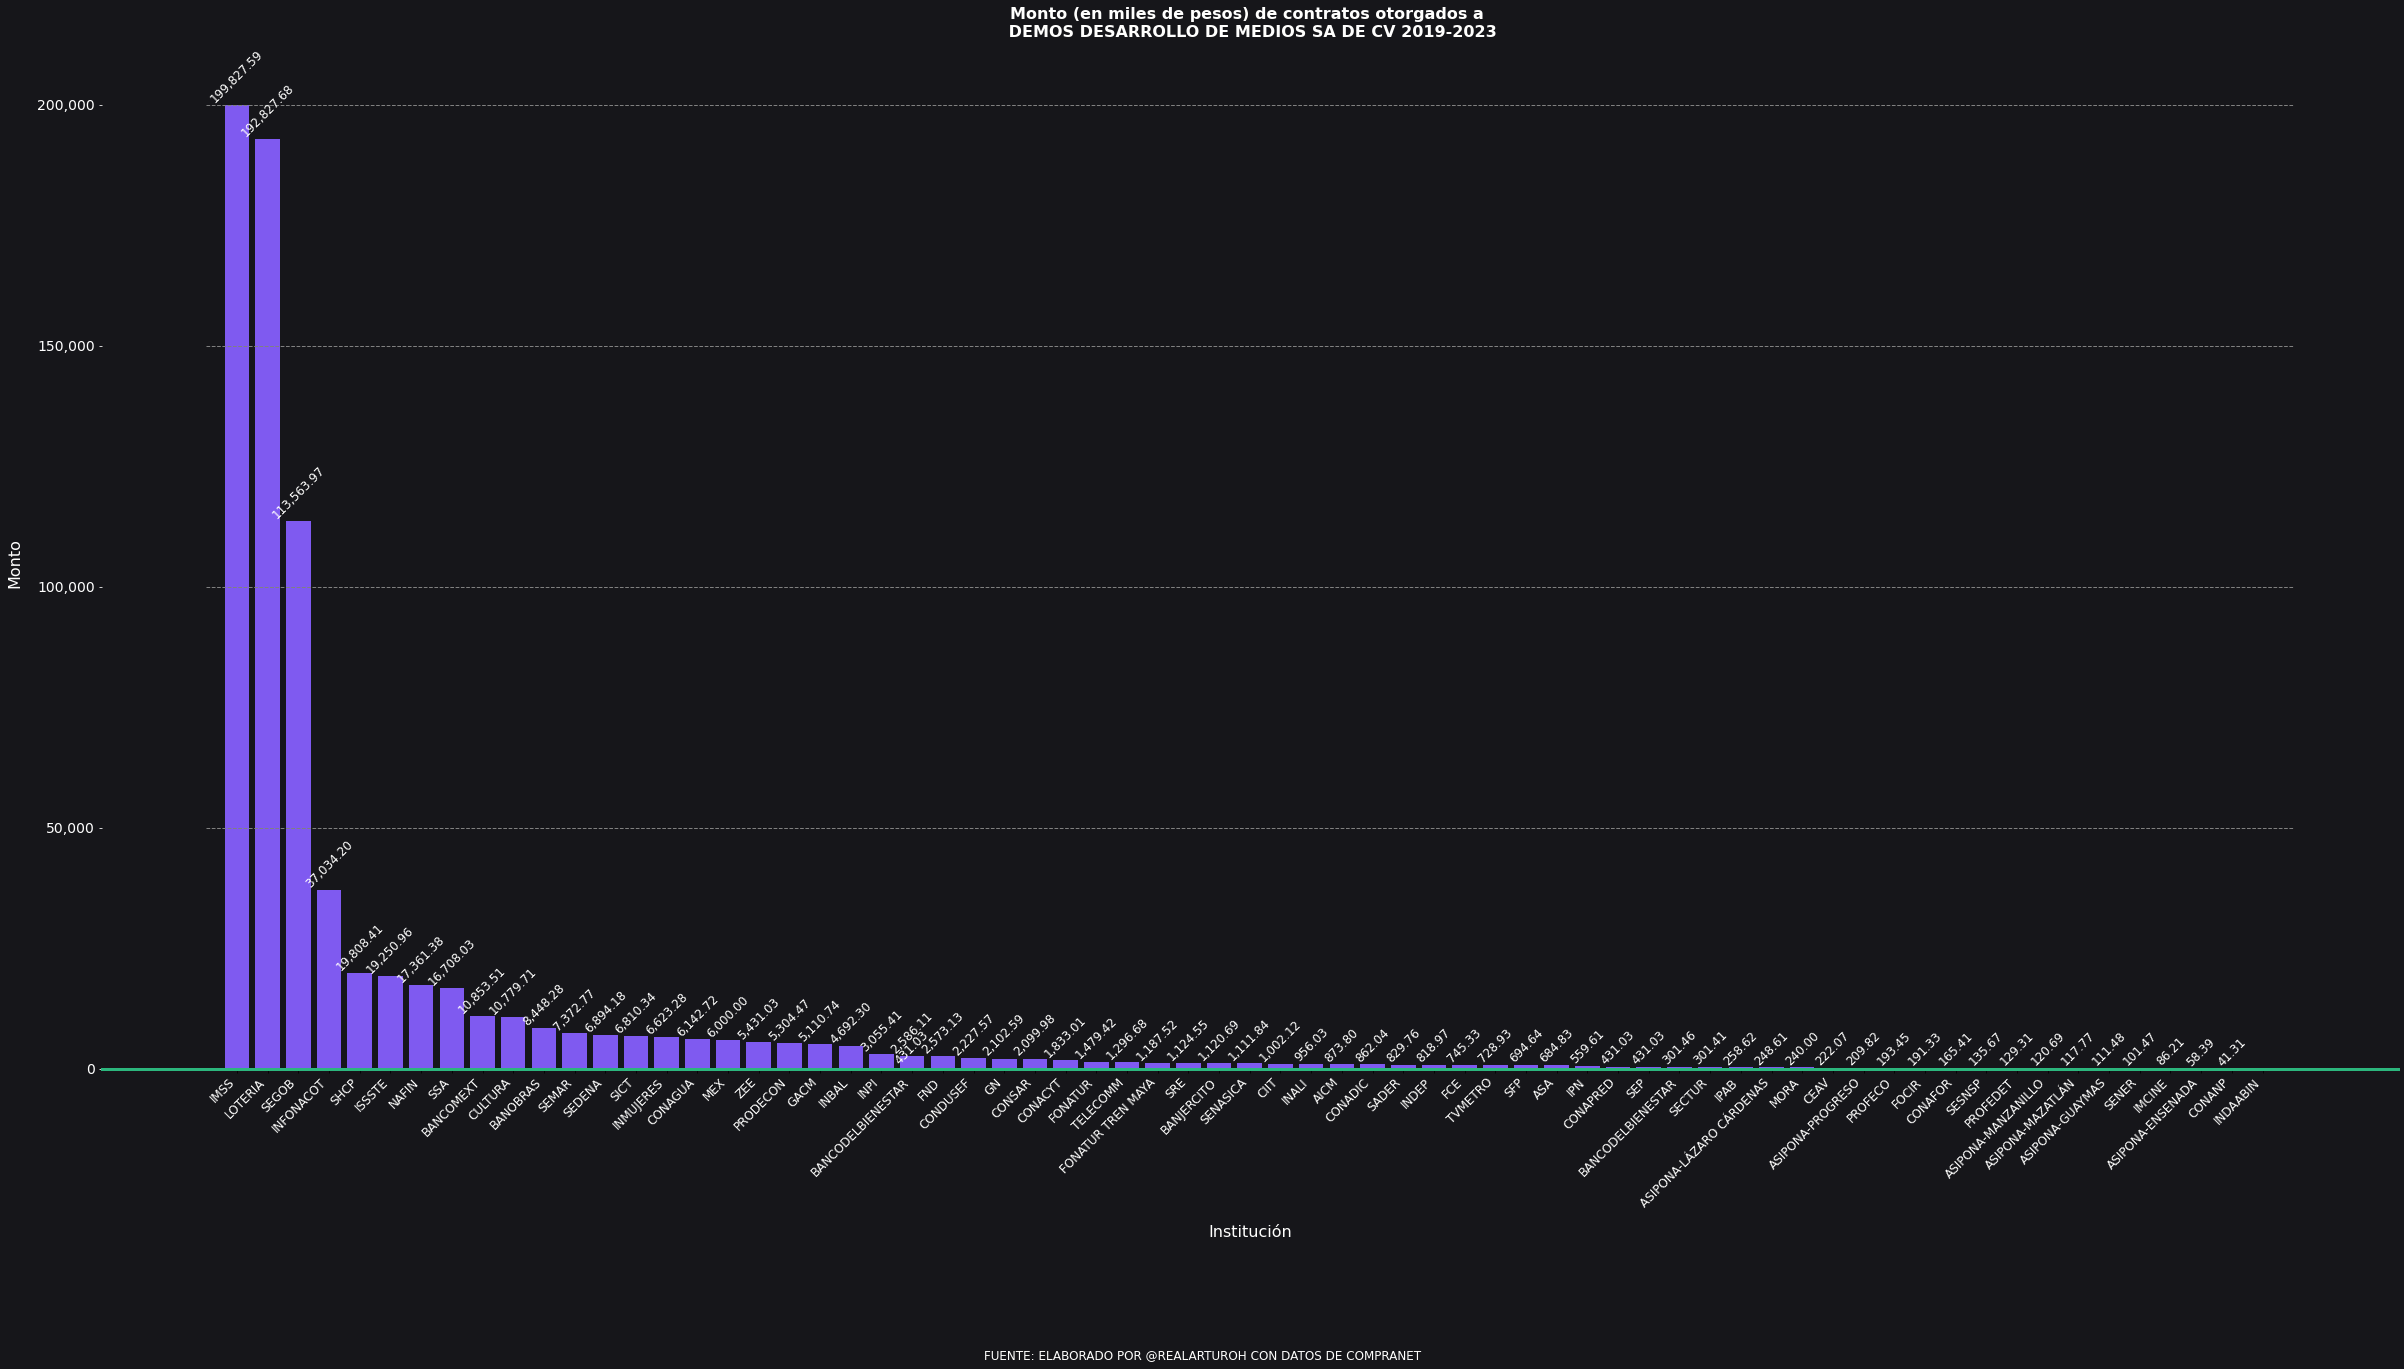

In [36]:
width = max(16, 0.5*len(instituciones))
height = width * (9/16)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.bar(instituciones, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados a \n {proveedor} 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_xlabel("Institución", fontsize=16, labelpad=15, color='#fffffe')
ax.set_ylabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(instituciones))))
ax.set_xticklabels(instituciones, fontsize=12, rotation=45, color='#fffffe', ha="right")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=14, colors='white')

ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
for y in np.arange(0, max(importe)+y_interval, y_interval):
    plt.hlines(y, xmin=-1, xmax=len(instituciones), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('#2cb67d')

for bar in bars:
    yval = bar.get_height()
    formatted_yval = "{:,.2f}".format(yval)
    ax.text(bar.get_x() + bar.get_width()/2, yval+0.1, formatted_yval, ha='center', va='bottom', fontsize=12, color='#fffffe', rotation=45)

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


### Resultados de búsqueda por proveedor

In [61]:
import pandas as pd

# Asumiendo que 'buscar' es tu DataFrame original

# Creando el DataFrame prov_df con sumas de importes
prov_df = buscar.groupby(['proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()
prov_df.sort_values(by='importe', ascending=False, inplace=True)

# Añadiendo la columna 'año_constitucion'
def convert_year(two_digit_year):
    if two_digit_year.isdigit():
        year_int = int(two_digit_year)
        if year_int > 23:
            return "19" + two_digit_year
        else:
            return "20" + two_digit_year
    else:
        return "unknown"

prov_df['año_constitucion'] = prov_df['rfc'].apply(lambda x: convert_year(str(x)[3:5]) if len(str(x)) >= 5 else "unknown")

# 1. Crear una tabla dinámica basada en el importe
pivot_df_importe = buscar.pivot_table(index='proveedor_o_contratista', columns='tipo_de_procedimiento', values='importe', aggfunc='sum', fill_value=0)

# 2. Convertir sumas en porcentajes
pivot_df_percentage = pivot_df_importe.divide(pivot_df_importe.sum(axis=1), axis=0) * 100
pivot_df_percentage.reset_index(inplace=True)

# 3. Fusionar con prov_df
prov_df = pd.merge(prov_df, pivot_df_percentage, on='proveedor_o_contratista', how='left')

# Opcional: mostrar el resultado
pd.options.display.float_format = '{:,}'.format
prov_df


,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES,OTRO
0,INTEGRA ARRENDA SA DE CV SOFOM ENR,AAN910409I35,"3,641,577,670.08",1991,NaN,NaN,NaN,NaN,NaN,NaN
1,IMPRESORES EN OFFSET Y SERIGRAFIA SC DE RL DE CV,IOS010313EG7,"1,308,203,128.92",2001,0.6633410216014453,0.0,0.0,99.33665897839855,0.0,0.0
2,CASANOVA VALLEJO SA DE CV,CVA910402GI5,"630,942,103.8",1991,0.0,0.0,0.0,0.0,100.0,0.0
3,COMERCIALIZADORA REALZA SA DE CV,CRE150423BF1,"628,845,000.0",2015,100.0,0.0,0.0,0.0,0.0,0.0
4,BUFETE EMPRESARIAL GTI SA DE CV,BEG141128JD5,"588,873,825.06",2014,9.869083594279056,0.0,0.0,90.13091640572095,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
667,AGRO H SA DE CV,AHX1709121Y9,"21,400.0",2017,100.0,0.0,0.0,0.0,0.0,0.0
668,CONMERA CONSORCIO MERCANTIL AMAC SA DE CV,CCM1607224U9,"13,300.0",2016,100.0,0.0,0.0,0.0,0.0,0.0
669,ESPACIOS PUBLICITARIOS ESTRATEGICOS SA DE CV,EPE0607251Q2,"11,650.0",2006,100.0,0.0,0.0,0.0,0.0,0.0
670,FUMITECNI INDUSTRIA Y HOGAR,FIH910606J83,"11,000.0",1991,0.0,0.0,100.0,0.0,0.0,0.0


In [64]:
import datetime

# Año actual
current_year = datetime.datetime.now().year

# Función para calcular la probabilidad de sospecha
def calculate_suspicion(row):
    suspicion_score = 0

    # Si la empresa se constituyó en los últimos 5 años
    if row['año_constitucion'] != 'unknown' and (current_year - int(row['año_constitucion'])) <= 5:
        suspicion_score += 0.5

    # Si más del 50% de su importe proviene de "ADJUDICACIÓN DIRECTA" o "INVITACIÓN A CUANDO MENOS 3 PERSONAS"
    if row.get("ADJUDICACIÓN DIRECTA", 0) + row.get("INVITACIÓN A CUANDO MENOS 3 PERSONAS", 0) > 50:
        suspicion_score += 0.5

    return suspicion_score

prov_df['probabilidad_sospecha'] = prov_df.apply(calculate_suspicion, axis=1)
prov_df


,proveedor_o_contratista,rfc,importe,año_constitucion,ADJUDICACIÓN DIRECTA,CONTRATO ENTRE ENTES PUBLICOS,INVITACIÓN A CUANDO MENOS 3 PERSONAS,LICITACIÓN PÚBLICA,OTRAS CONTRATACIONES,OTRO,probabilidad_sospecha
0,INTEGRA ARRENDA SA DE CV SOFOM ENR,AAN910409I35,"3,641,577,670.08",1991,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,IMPRESORES EN OFFSET Y SERIGRAFIA SC DE RL DE CV,IOS010313EG7,"1,308,203,128.92",2001,0.6633410216014453,0.0,0.0,99.33665897839855,0.0,0.0,0.0
2,CASANOVA VALLEJO SA DE CV,CVA910402GI5,"630,942,103.8",1991,0.0,0.0,0.0,0.0,100.0,0.0,0.0
3,COMERCIALIZADORA REALZA SA DE CV,CRE150423BF1,"628,845,000.0",2015,100.0,0.0,0.0,0.0,0.0,0.0,0.5
4,BUFETE EMPRESARIAL GTI SA DE CV,BEG141128JD5,"588,873,825.06",2014,9.869083594279056,0.0,0.0,90.13091640572095,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
667,AGRO H SA DE CV,AHX1709121Y9,"21,400.0",2017,100.0,0.0,0.0,0.0,0.0,0.0,0.5
668,CONMERA CONSORCIO MERCANTIL AMAC SA DE CV,CCM1607224U9,"13,300.0",2016,100.0,0.0,0.0,0.0,0.0,0.0,0.5
669,ESPACIOS PUBLICITARIOS ESTRATEGICOS SA DE CV,EPE0607251Q2,"11,650.0",2006,100.0,0.0,0.0,0.0,0.0,0.0,0.5
670,FUMITECNI INDUSTRIA Y HOGAR,FIH910606J83,"11,000.0",1991,0.0,0.0,100.0,0.0,0.0,0.0,0.5


In [50]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

prov_df2 = prov_df
prov_df2.sort_values(by='importe', ascending=True, inplace=True)
prov_df2 = prov_df2.tail(20)

proveedores = prov_df2['proveedor_o_contratista'].values
importe = prov_df2['importe'].values / 1e3  # Convertimos a miles


In [51]:
# Determine the order of magnitude of the max value
magnitude = 10 ** (math.floor(math.log10(max(importe))))

# Adjust the interval based on the magnitude
if max(importe) / magnitude < 2.5:
    x_interval = 0.5 * magnitude
elif max(importe) / magnitude < 5:
    x_interval = magnitude
else:
    x_interval = 2 * magnitude


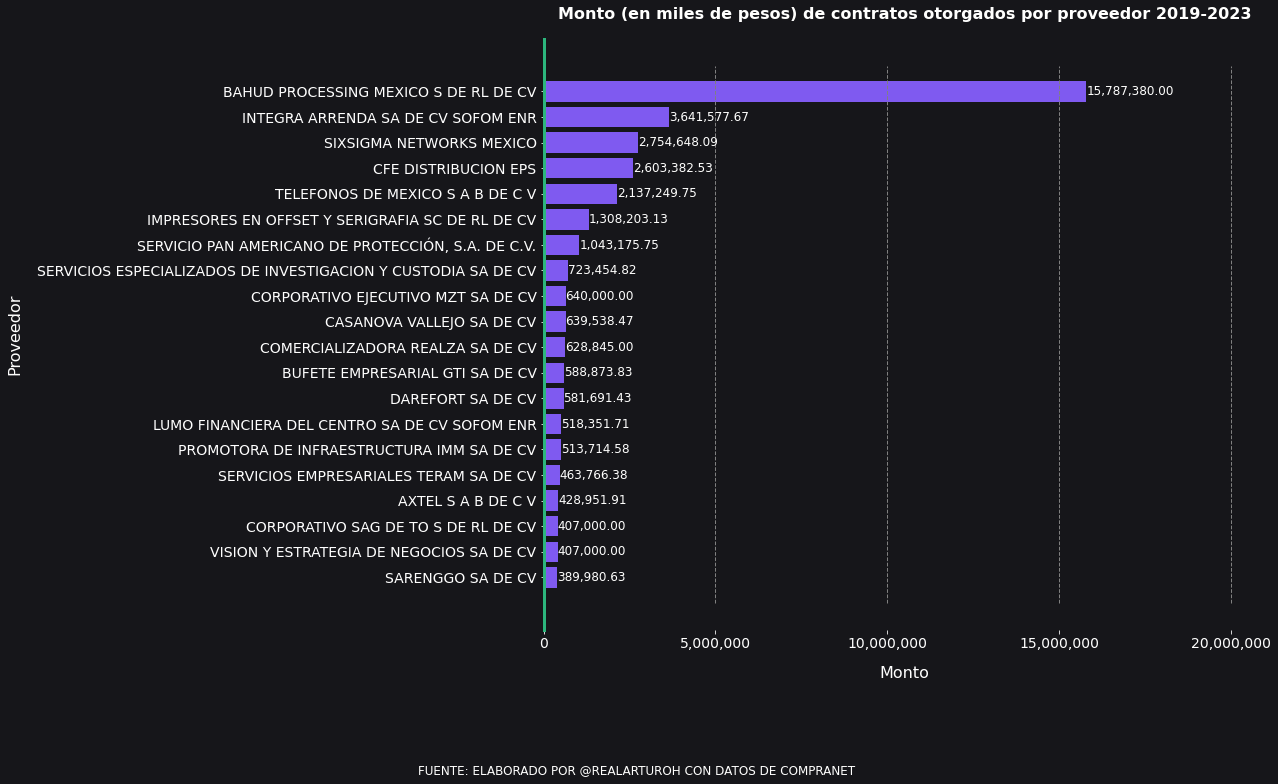

In [52]:
height = max(10, 0.5 * len(proveedores))
width = height * (16/9)

fig, ax = plt.subplots(figsize=(width, height))
bars = ax.barh(proveedores, importe, color='#7f5af0')

ax.set_title(f"Monto (en miles de pesos) de contratos otorgados por proveedor 2019-2023", fontsize=16, pad=20, fontweight='bold', color='#fffffe')
ax.set_ylabel("Proveedor", fontsize=16, labelpad=15, color='white')
ax.set_xlabel("Monto", fontsize=16, labelpad=15, color='white')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='x', labelsize=14, colors='white')

ax.xaxis.set_major_locator(ticker.MultipleLocator(x_interval))
for x in np.arange(0, max(importe)+x_interval, x_interval):
    plt.vlines(x, ymin=-1, ymax=len(proveedores), colors='gray', linestyles='dashed', linewidth=1)

fig.set_facecolor('#16161a')
ax.set_facecolor('#16161a')

for spine in ['bottom', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('#2cb67d')
ax.tick_params(axis='y', labelsize=14, colors='white')

for bar in bars:
    xval = bar.get_width()
    formatted_xval = "{:,.2f}".format(xval)
    ax.text(xval + 0.1, bar.get_y() + bar.get_height()/2, formatted_xval, ha='left', va='center', fontsize=12, color='#fffffe')

plt.figtext(0.5, -0.08, "FUENTE: ELABORADO POR @REALARTUROH CON DATOS DE COMPRANET", ha="center", fontsize=12, color='#fffffe')
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()
